# Build a new transient


By inherating ``Transient`` you can define any new transient you want. 

To elements are required:
  - *rate*: you must provide a volumetric rate as ``_VOLUME_RATE = `float` ``
  - *model*: you must provide the model, that is, how the transient parameters are draw ``_MODEL = `dict` ``

In [13]:
from skysurvey.target import Transient

## Start with an example

This example below is typically what you want to do

In [14]:
import numpy as np

class NewTransient( Transient ):
    _KIND = "SNnew"
    _TEMPLATE_SOURCE = "no_defined_yet" # sncosmo template 
    _VOLUME_RATE = 1 * 10**3 # volumetric rate of the transient

    _MODEL = dict( # Draw variable from a very simple method (only needs size as param).
                   magabs = {"model":"my_defined_method"},

                   # draw_redshift is defined for Transients
                   redshift = {"param":{"zmax":0.2},  "as":"z"}, # you can change the stored variable name.

                   # use a func drawing variables directly (e.g. numpy.random. )
                   noise = {"model": np.random.normal, 
                            "param":{"loc":0, "scale":0.5}},

                   # use one of the few pre-defined method e.g., magabs_to_magobs 
                    magobs = {"model": "magabs_to_magobs", 
                                "input":["z","magabs"]}, # "magabs_to_magobs has 2 mandatory inputs"

                    bias = {"model":np.random.uniform, 
                            "param":{"low":-1, "high":+1}},

                    # Create a complexe method that needs input.
                    magobs_eff = {"model": "my_method_needs_input", 
                                    "input":["magobs","bias"]},# "my_method_needs_input has 2 mandatory inputs"
                 )

    def my_defined_method(self, size=None, boundaries=[-14,-18]):
        """ """
        return np.random.uniform(*boundaries, size=size)

    # remark here, no size, it will be that of p1 and noise
    def my_method_needs_input(self, magobs, bias):
        """ returns ``scale*(a*coef + noise)``"""
        return magobs+bias

all methods from Transients, such as the ``from_draw()`` class method or the ``show_scatter()`` are then passed to ``NewTransient``

In [15]:
newtarget = NewTransient.from_draw(5000) # all method
newtarget.data

,magabs,z,noise,magobs,bias,magobs_eff
0,-14.004999,0.1935,-1.085276,25.941622,0.060641,26.002264
1,-14.928859,0.1875,-0.441983,24.941761,0.212911,25.154672
2,-14.005151,0.1575,-0.398059,25.447895,0.323595,25.771490
3,-16.538967,0.1865,-0.232188,23.318768,0.411220,23.729988
4,-17.657390,0.1255,0.234578,21.259070,0.520404,21.779474
...,...,...,...,...,...,...
4995,-17.291165,0.1295,0.279163,21.698957,-0.040622,21.658335
4996,-15.629493,0.1495,-0.105805,23.699687,0.024268,23.723954
4997,-16.901473,0.1135,0.247352,21.779960,0.966993,22.746953
4998,-17.820755,0.1165,-0.387742,20.921552,0.485585,21.407137


Text(0, 0.5, 'bias')

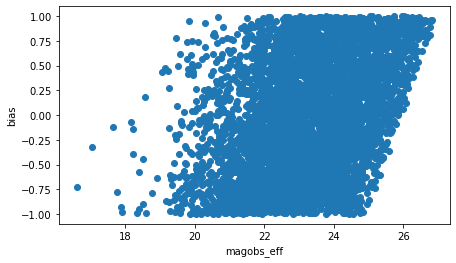

In [16]:
fig = newtarget.show_scatter("magobs_eff","bias")
ax = fig.axes[0]

ax.set_xlabel("magobs_eff")
ax.set_ylabel("bias")

## Dissecting what happened

### Inheriting Transient

This bit of code specifies that `NewTransient` has all the `Transient` attributes and methods, plus all what goes next. Any attribute or method explicitely writting in `NewTransient` overwrite these of `Transient` (see [python class doc](https://docs.python.org/3/tutorial/classes.html))

```python
class NewTransient( Transient ):
```

### The generic information

You can provide the kind of transient in `_KIND`. This is just for having a name, say a SNII or here a `SNnew`.

The ``sncosmo.Model`` source you want to use to generate spectrum of lightcurve from the transient parameters if given in `_TEMPLATE_SOURCE`.

The volumetric rate that is used to see how to draw the transient redshift distribution is given as `_VOLUME_RATE`.


```python
    _KIND = "SNnew" # 
    _TEMPLATE_SOURCE = "no_defined_yet" # sncosmo template 
    _VOLUME_RATE = 1 * 10**3 # 
```

### Most importantly the **model**

The `_MODEL` attribute specifies how the data are drawn. 

See the documentation below to understand how to construct on.


```python
    _MODEL = dict( # Draw variable from a very simple method (only needs size as param).
                   magabs = {"model":"my_defined_method"},

                   # draw_redshift is defined for Transients
                   redshift = {"param":{"zmax":0.2},  "as":"z"}, # you can change the stored variable name.

                   # use a func drawing variables directly (e.g. numpy.random. )
                   noise = {"model": np.random.normal, 
                            "param":{"loc":0, "scale":0.5}},

                   # use one of the few pre-defined method e.g., magabs_to_magobs 
                    magobs = {"model": "magabs_to_magobs", 
                                "input":["z","magabs"]}, # "magabs_to_magobs has 2 mandatory inputs"

                    bias = {"model":np.random.uniform, 
                            "param":{"low":-1, "high":+1}},

                    # Create a complexe method that needs input.
                    magobs_eff = {"model": "my_method_needs_input", 
                                    "input":["magobs","bias"]},# "my_method_needs_input has 2 mandatory inputs"
                 )

```

### additional methods

The two additional methods are here used for as function for the `_MODEL`, `my_defined_method` (for `magabs`) and `my_method_needs_input` for `magobs_eff`.

**Remark** that ``magabs_to_magobs`` is a method already defined in `Transient`.

```python
    def my_defined_method(self, size=None, boundaries=[-14,-18]):
        """ """
        return np.random.uniform(*boundaries, size=size)

    # remark here, no size, it will be that of p1 and noise
    def my_method_needs_input(self, magobs, bias):
        """ returns ``scale*(a*coef + noise)``"""
        return magobs+bias
```

***
## Build a transient model

### Concept
To generate ``data``, the code reads **model** line-by-line and follows the instructions it contains. 

In this SNeIa example, **model** contains 8 entries. So the generated ``data`` will contains at least 8 columns (see the *as* option).

#### *model*, *param*, *as*, *input*

A **model** entry accepts 4 keywords:
  1. *model*: (name of) the function used to draw the sample, e.g. np.random.uniform ;
  2. *param*: options that enter the function as kwargs ;
  3. *as*: (list of) name(s) of the column on the resulting ``data`` ;
  4. *input*: list of already drawn entry used as argument for the *model* function (see e.g. ``magobs``)

#### the *input* option making **model**  a "DAG"
The *input* option enables you to generate self-consistent parameters. 

For instance, the absolute magnitude of a SNeIa depends on its stretch and color (following the ``alpha*x_1 - beta*c `` Tripp's relation). Hence, once the ``x_1``and ``c`` (independent) variables have been drawn, the SNeIa absolute magnitude (``magabs``) can be obtained using as input the already drawn ``x_1`` and ``c`` parameters. Same goes for the observed magnitude, it only dependents on the absolute magnitude ``magabs`` and the redshift ``z``. 

The (potentially complex) connections between the variables enabled by the *input* corresponds to the creation a [Directed acyclic graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph).
You can complexify as you which your **model** creating as many variables and intermediate variables as you want.

#### the *model* option, where to define the function

The *model* option is the function that will be used to generate the dataset. In principle, it should should accept ``size`` as parameters and return N=size values.

In your **model**, the *model* option can be a function or a string. 
 - a function will be used as such
 - a string will be converted in function, it typically means you input a method of the class ; though more advanced tools exist, see "Build a new Model" documentation.
 
### Applied to NewTransient


In the ``NewTransient`` example, 

  1. the first draw parameters will be ``magabs`` and will be drawn using the ``my_defined_method()`` function. This one is a method of ``NewTransient``.
```python
                   # Draw variable from a very simple method (only needs size as param).
                   magabs = {"model":"my_defined_method"},
```

  2. the redshift is a special parameter drawn following the volumetric rate you defined above. Here we say we want to go up to zmax is 0.2 (`"param":{"zmax":0.2}`, zmax is an option of `self.draw_redshift()`. In addition, we want the redshift to be store as `z` in the dataframe, not "redshift".

```python
                   # draw_redshift is defined for Transients
                   redshift = {"param":{"zmax":0.2},  "as":"z"}, # you can change the stored variable name.

```

  3. we want noise, we simply want to use the [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) function to draw it. it will be centered on 0 with a sigma (scale) of 0.5 
```python
                   # use a func drawing variables directly (e.g. numpy.random. )
                   noise = {"model": np.random.normal, 
                            "param":{"loc":0, "scale":0.5}},
```
  4. generate the observed magnitude given the redshift (**z**) and the absolute magnitude (**magabs**) you have drawn in step 2 and 1, respectively. The `magabs_to_magobs` method is already defined in `Transient` so no need to re-defined it in `NewTransient`. The *input* option specifies that it is the **z** and **magabs** drawn before that should be used.
   
```python
                   # use one of the few pre-defined method e.g., magabs_to_magobs 
                    magobs = {"model": "magabs_to_magobs", 
                                "input":["z","magabs"]}, # "magabs_to_magobs has 2 mandatory inputs"

```

  5. just create a new random variable, called **bias** draw using the numpy function.
```python
                    bias = {"model":np.random.uniform, 
                            "param":{"low":-1, "high":+1}},
```

  6. The final parameters `magobs_eff` is obtained using the method `my_method_needs_input` and takes as input the already drawn `magobs` and `bias`.
```python
                    # Create a complexe method that needs input.
                    magobs_eff = {"model": "my_method_needs_input", 
                                    "input":["magobs","bias"]} # "my_method_needs_input has 2 mandatory inputs"


```

And here you go.